# healpy tutorial

$\texttt{healpy}$ is a python wrapper for a $\texttt{C++}$ library called HEALPix (Hierarchical Equal Area isoLatitude Pixelization). It was initially developed with CMB data analysis in mind, but is useful for any situation where you have to handle functions on the sphere (i.e. pretty much all of astronomy and observational cosmology).

Some useful links:
- healpy documentation (very thorough, should be your go-to when you get stuck) https://healpy.readthedocs.io/en/latest/
- original HEALPix documentation https://healpix.jpl.nasa.gov/index.shtml
- the HEALPix paper (with 2000+ citations!) https://inspirehep.net/record/659804

# Basics
Let's start by importing the $\texttt{healpy}$ library, along with some other useful things.

In [1]:
%matplotlib inline
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({"text.usetex":True})
plt.rcParams.update({"font.size":20})

$\texttt{healpy}$ is, at its heart, an efficient algorithm for tiling the sphere into equal-area "pixels". We control the number of pixels (equivalently, the angular resolution of the map) using the "nside" parameter, which must be an integer power of $2$, less than $2^{30}$. Shown below are some HEALPix pixelisations for various values of nside.

In [3]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://healpix.jpl.nasa.gov/images/healpixGridRefinement.jpg")

Let's set a reasonable value of nside.

In [4]:
nside = 2**9

$\texttt{healpy}$ provides some useful functions for converting this into the corresponding number of pixels, pixel area, and angular resolution.

In [5]:
npix = hp.nside2npix(nside)
pixarea = hp.nside2pixarea(nside)
resol = hp.nside2resol(nside)

print("the number of pixels is {}".format( npix ))
print("the pixel area in steradians is {:.2e}".format( pixarea ))
print("the angular resolution in radians is {:.2e}".format( resol ))

the number of pixels is 3145728
the pixel area in steradians is 3.99e-06
the angular resolution in radians is 2.00e-03


Let's create a map. A $\texttt{healpy}$ map is just a $\texttt{numpy}$ array, with each number in the array corresponding to the value in one pixel.

In [6]:
map_range = np.arange(npix)

In order to visualise this map, we use one of the plotting functions from the module $\texttt{healpy.visufunc}$. There are lots of different ways to project the sphere $S^2$ onto the plane $\mathbb{R}^2$ (like this screen), but let's use the Mollweide projection.

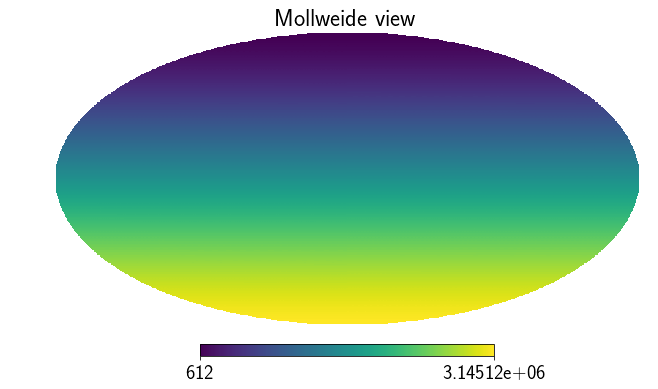

In [7]:
hp.mollview(map_range)

The $\texttt{healpy.visufunc.graticule}$ function can be used to add grid lines.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


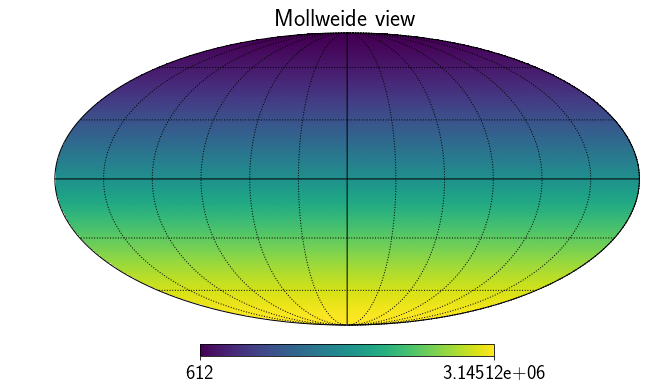

In [8]:
hp.mollview(map_range)
hp.graticule()

We can also use the $\texttt{cmap}$ argument to change the colourmap (the default is "viridis"; see https://matplotlib.org/tutorials/colors/colormaps.html for a full list).

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


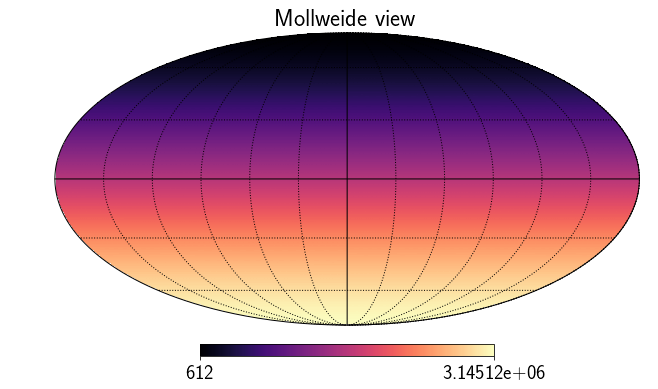

In [9]:
hp.mollview(map_range, cmap="magma")
hp.graticule()

This map is pretty artificial-looking. Let's simulate a Gaussian random noise map using $\texttt{numpy}$'s random number generator.

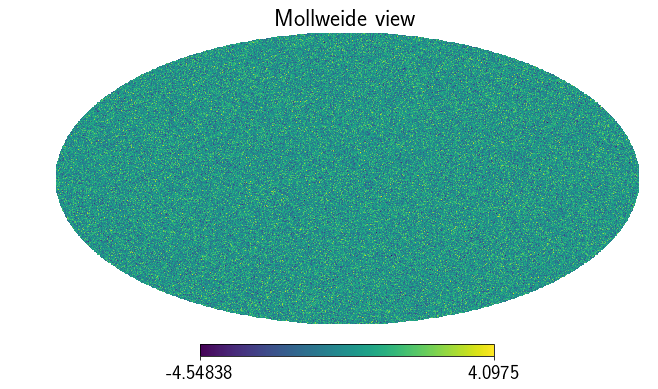

In [10]:
map_gauss = np.random.normal(size=npix)
hp.mollview(map_gauss)

$\texttt{healpy}$ provides some useful functions for converting between a given pixel's index within the map array, its angular coordinates, and the unit vector pointing in its direction. Let's find the index of the pixel with coordinates $\theta=\pi/4$, $\phi=\pi/2$, then convert this to a vector and check it has unit length.

In [11]:
pix = hp.ang2pix(nside, np.pi/4.0, np.pi/2.0)
print("the pixel index for coordinates theta=pi/4, phi=pi/2 is {}".format(pix))

vec = hp.pix2vec(nside, pix)
print("the unit vector pointing to this pixel is {}".format(vec))

vec = hp.ang2vec(np.pi/4.0, np.pi/2.0)
print("the unit vector point to those coordinates is {}".format(vec))
print("this vector has length {}".format(vec.dot(vec)))

the pixel index for coordinates theta=pi/4, phi=pi/2 is 460320
the unit vector pointing to this pixel is (-0.0011571238232320875, 0.7071813576359993, 0.70703125)
the unit vector point to those coordinates is [4.32978028e-17 7.07106781e-01 7.07106781e-01]
this vector has length 1.0


Note that the outputs of $\texttt{pix2vec}$ and $\texttt{ang2vec}$ are slightly different---this is because $\texttt{pix2vec}$ returns a vector pointing toward the centre of the pixel, which is slightly offset from our original coordinates.

Also, notice that functions which depend on the pixelisation scheme must take $\texttt{nside}$ as an argument.

#### Exercise 1: Find the angle between the minimum and maximum values of the Gaussian map we've created.

In [12]:
vec_max = np.array(hp.pix2vec(nside, map_gauss.argmax()))
vec_min = np.array(hp.pix2vec(nside, map_gauss.argmin()))
ang_sep = np.arccos(vec_max.dot(vec_min))
print ang_sep

1.8829047982002793


# Fun with LIGO/Virgo alerts
Now for a fun example with some actual data. Let's download the publicly-available skymap for GW190425, a recent binary neutron star signal detected by LIGO/Virgo. This is just a HEALPix map of the probability distribution of the source's sky location.

The map is stored in a $\texttt{.fits}$ file, which is a special file format often used in astronomy and cosmology for full-sky maps. We can read it into python using the $\texttt{healpy.read_map}$ function, which will automatically determine the correct $\texttt{nside}$ to use.

In [14]:
hp.nside2npix(256)

786432

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


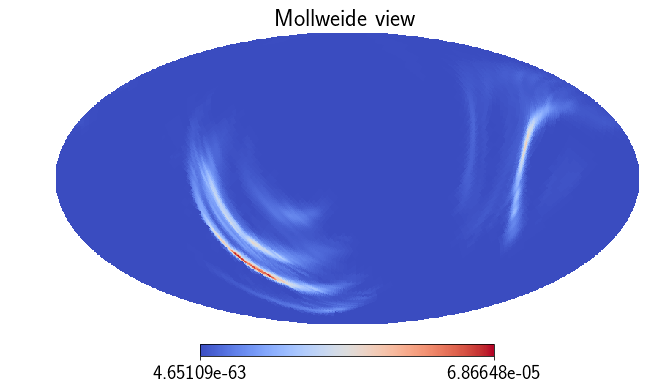

In [13]:
#! wget -v https://gracedb.ligo.org/api/superevents/S190425z/files/LALInference.fits.gz
map_gw = hp.read_map("LALInference.fits.gz")
nside = hp.get_nside(map_gw)
hp.mollview(map_gw, cmap="coolwarm")

We can check that the pixel values sum to unity, as they should for a probability distribution.

In [15]:
print np.sum(map_gw)

1.0000000000000002


Clearly the probability distribution is peaked in a relatively small area. We might want to zoom in on this area. To do so, we can use a gnomonic projection around a given point, using $\texttt{healpy.gnomview}$.

In the cell below we'll find the angular coordinates of the maximum-probability pixel, and zoom in to a 1000-by-1000 pixel area centred on that point. (Note the use of the "lonlat" argument, which ensures the angular coordinates are in the right format for $\texttt{gnomview}$.)

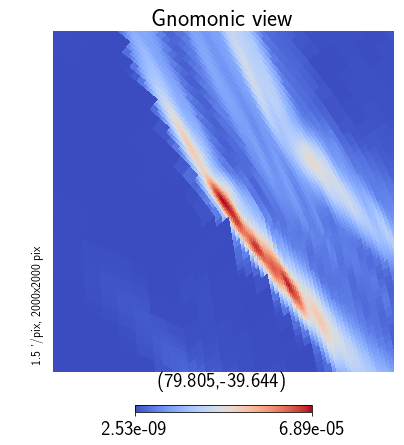

In [16]:
ang_max = hp.pix2ang(nside, map_gw.argmax(), lonlat=True)
hp.gnomview(map_gw, rot=ang_max, xsize=2000, ysize=2000, cmap="coolwarm")

#### Exercise 2: Estimate the size in steradians of the 90% confidence region---i.e. the smallest possible region of the sky which contains 90% of the total probability.

In [19]:
cum_prob = 0.0
pixel_count = 0
map_sort = list(np.sort(map_gw))

while cum_prob < 0.9:
    cum_prob += map_sort.pop()
    pixel_count += 1

pixarea = hp.nside2pixarea(nside)
pixel_count*pixarea/(4.0*np.pi)

0.18085352579752603

# Spherical harmonics and angular power spectra

Let's start by defining a scale-invariant angular power spectrum. Note that the maximum $\ell$ we can use is set by the resolution of the maps we'll be working with, and is limited to $\ell_\mathrm{max}=3\times\texttt{nside}-1$.

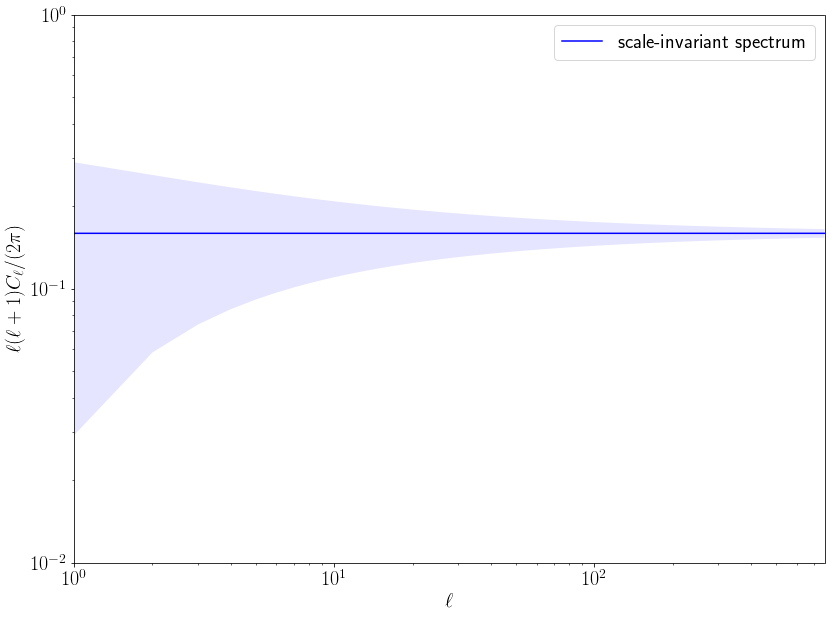

In [20]:
lmax = 3*nside-1
ell = np.arange(lmax+1)
C_ell = np.array([np.power((l+1.0)*np.max([l,1.0]),-1.0) for l in ell])
sigma = np.array([np.sqrt(2.0*np.power(2.0*l+1.0,-1.0)) for l in ell])

D_ell = np.array([0.5*l*(l+1.0)*C_ell[l]/np.pi for l in ell])
D_ell_plus_sigma  = np.array([D_ell[l]*(1.0+sigma[l]) for l in ell])
D_ell_minus_sigma = np.array([D_ell[l]*(1.0-sigma[l]) for l in ell])

fig = plt.figure()
fig.set_size_inches(12, 9)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)C_\ell/(2\pi)$")
plt.loglog(ell, D_ell, "b", label=r"scale-invariant spectrum")
plt.fill_between(ell, D_ell_plus_sigma, 
                      D_ell_minus_sigma, 
                      where=D_ell_plus_sigma>=D_ell_minus_sigma, 
                      facecolor="b", alpha=0.1)
plt.xlim(1, lmax)
plt.ylim(0.01, 1.0)
plt.legend(loc=0)
fig.tight_layout()

One of the most common things you'll want to do with $\texttt{healpy}$ is to generate a map from a given spectrum. This is done using the function $\texttt{healpy.synfast}$ (where the "syn" stands for "synthesise").

What we are doing here is effectively drawing each $a_{\ell m}$ from a Gaussian distribution with variance $C_\ell$. Since this is a random process, notice that rerunning this cell leads to a different map each time.

<Figure size 1152x648 with 0 Axes>

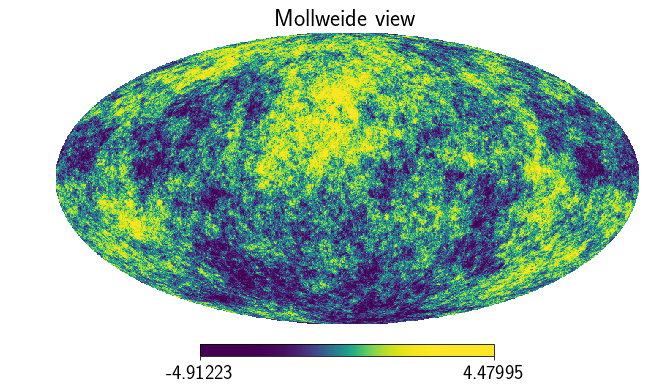

In [22]:
map_scale_inv = hp.synfast(C_ell, nside, new=True, verbose=False)

fig = plt.figure()
fig.set_size_inches(16, 9)
hp.mollview(map_scale_inv, norm="hist")

We'll also often want to do the reverse process: analyse a given map to find its spectrum. We do this with $\texttt{healpy.anafast}$.

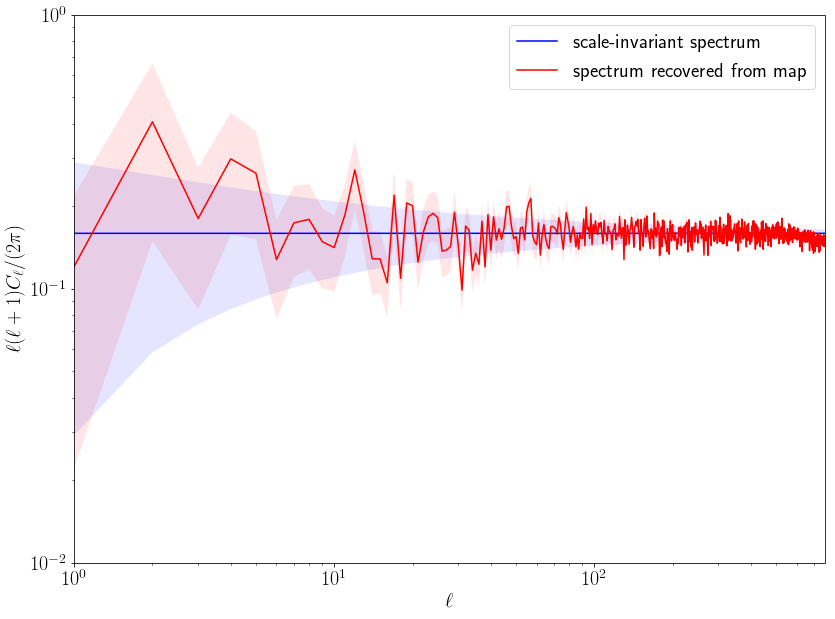

In [23]:
C_ell_ana = hp.anafast(map_scale_inv)

D_ell_ana = np.array([0.5*l*(l+1.0)*C_ell_ana[l]/np.pi for l in ell])
D_ell_ana_plus_sigma  = np.array([D_ell_ana[l]*(1.0+sigma[l]) for l in ell])
D_ell_ana_minus_sigma = np.array([D_ell_ana[l]*(1.0-sigma[l]) for l in ell])

fig = plt.figure()
fig.set_size_inches(12, 9)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)C_\ell/(2\pi)$")
plt.loglog(ell, D_ell, "b", label=r"scale-invariant spectrum")
plt.fill_between(ell, D_ell_plus_sigma, 
                      D_ell_minus_sigma, 
                      where=D_ell_plus_sigma>=D_ell_minus_sigma, 
                      facecolor="b", alpha=0.1)
plt.loglog(ell, D_ell_ana, "r", label=r"spectrum recovered from map")
plt.fill_between(ell, D_ell_ana_plus_sigma,
                      D_ell_ana_minus_sigma, 
                      where=D_ell_ana_plus_sigma>=D_ell_ana_minus_sigma, 
                      facecolor="r", alpha=0.1)
plt.xlim(1, lmax)
plt.ylim(0.01, 1.0)
plt.legend(loc=0)
fig.tight_layout()

Notice that the recovered spectrum is *not* the same as the one we injected, due to cosmic variance. We should expect the points on the red line to be randomly distributed around the points on the blue line, with variance equal to $2C_\ell^2/(2\ell+1)$. Let's check this by creating a histogram.

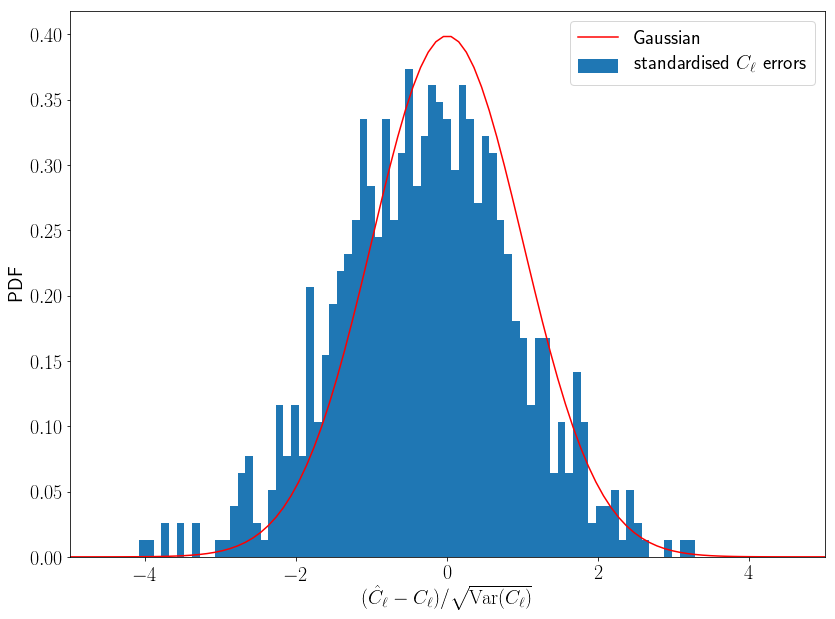

In [24]:
std_errors = np.array([(C_ell_ana[l]-C_ell[l])/(C_ell[l]*sigma[l]) for l in ell])

bins = np.linspace(-5.0, +5.0, num=100)
gaussian = np.array([np.power(2.0*np.pi,-0.5)*np.exp(-0.5*bins[x]**2.0) for x in xrange(100)])

fig = plt.figure()
fig.set_size_inches(12, 9)
plt.xlabel(r"$(\hat{C}_\ell-C_\ell)/\sqrt{\mathrm{Var}(C_\ell)}$")
plt.ylabel("PDF")
n, bins, patches = plt.hist(std_errors, bins=bins, density=True, label=r"standardised $C_\ell$ errors")
plt.plot(bins, gaussian, "r", label="Gaussian")
plt.xlim(-5.0, +5.0)
plt.legend(loc=0)
fig.tight_layout()

We may also want to work in terms of the $a_{\ell m}$'s. There are two ways to do this: either use $\texttt{healpy.map2alm}$ to calculate the $a_{\ell m}$'s of a given map, or use $\texttt{healpy.synalm}$ to randomly generate a set of $a_{\ell m}$'s from a given spectrum. The conversion from $a_{\ell m}$'s back to a map or a spectrum are achieved with $\texttt{healpy.alm2map}$ and $\texttt{healpy.alm2cl}$ respectively.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


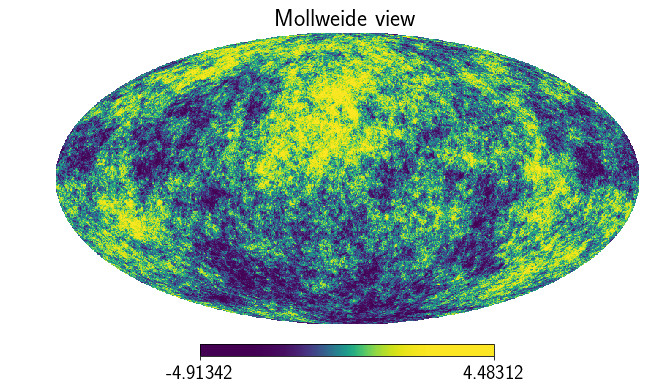

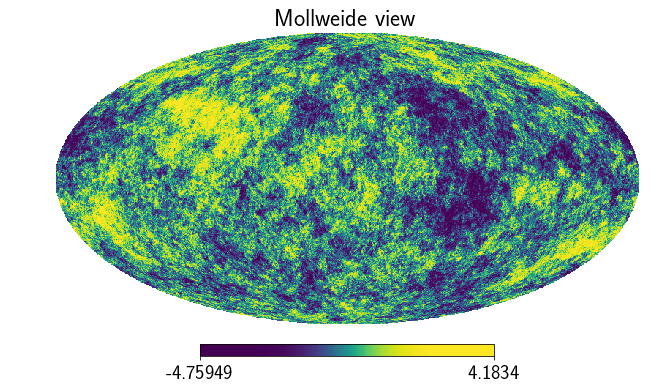

In [25]:
alm_map = hp.map2alm(map_scale_inv)
alm_syn = hp.synalm(C_ell, new=True)

hp.mollview(hp.alm2map(alm_map, nside), norm="hist")
hp.mollview(hp.alm2map(alm_syn, nside), norm="hist")

Both $\texttt{alm_map}$ and $\texttt{alm_syn}$ in the previous cell are $\texttt{numpy}$ arrays, with each element corresponding to a particular $(\ell,m)$. However, the order that $\texttt{healpy}$ puts these in within the array is pretty counter-intuitive, which can be annoying when you want to access a particular $a_{\ell m}$ from the array.

Luckily, $\texttt{healpy}$ provides a couple of functions for this: $\texttt{healpy.Alm.getidx}$ tells you the index in the array of a particular $(\ell,m)$, while $\texttt{healpy.Alm.getlm}$ does the converse. Both require $\ell_\mathrm{max}$ as an argument, as this determines the order in which the $a_{\ell m}$'s are stored. You can find out the $\ell_\mathrm{max}$ of a given array using $\texttt{healpy.Alm.getlmax}$.

In [26]:
lmax = hp.Alm.getlmax(len(alm_syn))
idx = hp.Alm.getidx(lmax, 100, 50)
(l, m) = hp.Alm.getlm(lmax, 120839)

print("we have l_max={}".format(lmax))
print("the l=100, m=50 mode is stored at index={}".format(idx))
print("index 120839 contains the l={0}, m={1} mode".format(l, m))

we have l_max=767
the l=100, m=50 mode is stored at index=37225
index 120839 contains the l=656, m=177 mode


#### Exercise 3: For $\ell=1500$, confirm that different $m$-modes are uncorrelated; i.e. check that for $m\ne m'$ the product $a_{\ell m}a^*_{\ell m'}$ is distributed around zero.

In [ ]:
ell = 1500
asq = []

for m1 in range(ell+1):
    for m2 in range(m1):
        idx1 = hp.Alm.getidx(lmax, ell, m1)
        idx2 = hp.Alm.getidx(lmax, ell, m2)
        alm1 = alm_syn[idx1]
        alm2 = alm_syn[idx2]
        asq.append(alm1*alm2.conj())

fig = plt.figure()
fig.set_size_inches(12, 9)
plt.hist(std_errors, bins=100, density=True)
plt.xlim(-5.0, +5.0)
fig.tight_l

# The real deal: Planck CMB maps

Let's download one of the Planck temperature maps and compute its spectrum. This map has a very high resolution ($\texttt{nside}=2^{11}$), so this may take a little while.

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/alex/.local/lib/python2.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


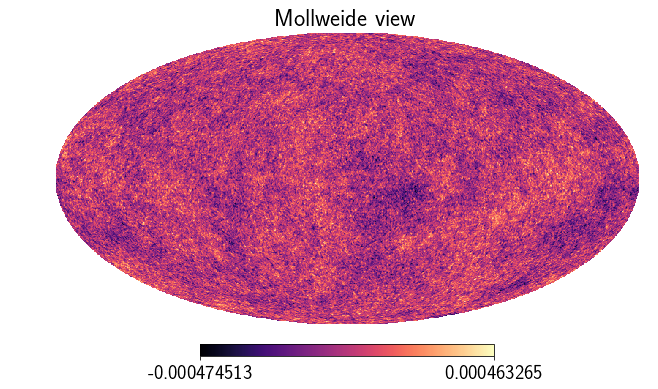

In [27]:
#! wget -v https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-commander-field-Int_2048_R2.01_full.fits
map_cmb = hp.read_map("COM_CMB_IQU-commander-field-Int_2048_R2.01_full.fits")
hp.mollview(map_cmb, cmap="magma")

In [ ]:
C_ell = hp.anafast(map_cmb)
ell = np.arange(len(C_ell))
D_ell = np.array([0.5*l*(l+1.0)*C_ell[l]/np.pi for l in ell])

fig = plt.figure()
fig.set_size_inches(12, 9)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)C_\ell/(2\pi)$")
plt.plot(ell, D_ell, "b")
plt.xlim(0, 2000)
plt.ylim(0.0, 7.0e-9)
fig.tight_layout()

#### Exercise 4: Plot a histogram of the pixel values to check that the CMB is Gaussian-distributed with zero mean and variance equal to $\sum_\ell(2\ell+1)C_\ell/(4\pi)$.

#### Exercise 5: Let's modify the Planck spectrum, and see how it changes the map. Add a new peak centred on $\ell=500$, with a Gaussian profile with variance $\sigma_\ell=500$, and height $1\times10^{-13}$.